In [109]:
%matplotlib inline
import scipy.io as sio
import random
import numpy as np
import scipy.misc as smp
import matplotlib.pyplot as plt
import cv2
from scipy.special import expit

In [110]:
# Note to future self, if relevant: Dimensionality checking was a headache. See 
# accompanying notebook derivations if you want more details/a migraine. Left out
# here for attempted cleanliness.
a = sio.loadmat('../../machine-learning-ex3/ex3/ex3data1.mat')
b = sio.loadmat('ex4weights.mat')

y_data = a['y']
x_data = a['X'] 

theta1 = b['Theta1']
theta2 = b['Theta2']

features = theta1.shape[1]
hidden_nodes = theta1.shape[0]
output = theta2.shape[0]

print "X, Y Shapes : ", x_data.shape, y_data.shape 
print "Theta Params : ", theta1.shape, theta2.shape

X, Y Shapes :  (5000, 400) (5000, 1)
Theta Params :  (25, 401) (10, 26)


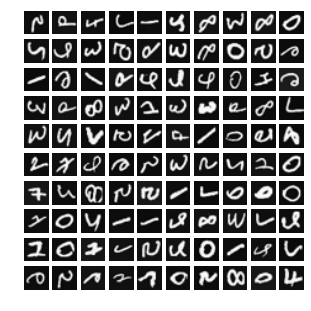

In [111]:
def displayData(data,rows,dim):

    # Display 100 random numbers. First grab images + reshape
    data_20x20 = [ np.reshape(data[im],(20,20)) for im in rows ] 
    images = [ smp.toimage( data_20x20[i]) for i in xrange(len(data_20x20)) ]

    # Images are rotated for now. Will fix this in the future
    plt.figure(figsize=(5,5))
    for i in xrange(len(images)):
        plt.subplot(dim,dim,i+1)
        plt.imshow(images[i],cmap='Greys_r')
        plt.axis('off')
    
    plt.show()

x_temp = np.array(a['X'])
hund = random.sample(range(0,5000), 100)
displayData(x_temp,hund,10)

In [112]:
x_data = np.insert(x_data,0,1,axis=1)

## 1.3 FEED IT FORWARD + COST

In [114]:
def flatten(T1,T2):
    unT1 = T1.reshape(T1.size,1,order='F')
    unT2 = T2.reshape(T2.size,1,order='F')
    return np.concatenate((unT1,unT2),axis=0)    

def reshape(theta_v): 
    t1 = theta_v[:features*hidden_nodes].reshape(hidden_nodes,features,order='F')
    t2 = theta_v[features*hidden_nodes:].reshape(output,hidden_nodes+1,order='F')
    return np.array([t1,t2]) 

def flattenX(X):
    unX = X.reshape(X.size,1,order='F')    
    return unX   

def reshapeX(X_flat):
    x = X_flat.reshape(float(len(X_flat))/(features),features,order='F')
    return x 

def h(x,theta):
    z = -1 * np.dot(x,theta)
    return 1./(1 + np.exp(z)) 

#Need to save all the z's for backprop later
def feedForward(theta_v,x):
    
    #Here, 'x' row becomes activation layer params 'a' after first layer
    acts = []
    zs   = []
    
    acts.append(x.reshape(x.shape[0],1))
    
    for t in theta_v :
        zs.append(np.dot(t,x).reshape((t.shape[0],1)))
             
        a = h(t,x) 
        x = np.insert(a,0,1)#,axis=1)  
        acts.append(x.reshape(x.shape[0],1))        
        
    #For future ariana's reference:
    hypoth = a # Also acts[-1]..clean this
    
    return hypoth, acts, zs

def computeCost(theta_flat,x_flat,y,lam):
    
    theta_v = reshape(theta_flat)
    x = reshapeX(x_flat)
    
    tot_cost = 0.
    
    for i in xrange(len(y)):
        
        y_nn = np.zeros([10,1])
        y_nn[y[i]-1] = 1
    
        hypoth,_,_ = feedForward(theta_v, x[i])
    
        logs = np.dot(-1*y_nn.T,np.log(hypoth).T) - \
               np.dot(1-y_nn.T, np.log(1-hypoth).T) 
    
        tot_cost += logs

    th_reg = 0.
    
    for t in theta_v:
        th_reg += np.sum(t*t)
    
    return 1./len(y) * (tot_cost + th_reg * lam / 2)

In [115]:
theta_v = np.array([theta1,theta2])

c0 = computeCost(flatten(theta1,theta2),flattenX(x_data),y_data,0.)
c1 = computeCost(flatten(theta1,theta2),flattenX(x_data),y_data,1.)

print "Computed cost (wo reg) is :", float(c0)
print "Computed cost (w/ reg) is :", float(c1)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Computed cost (wo reg) is : 0.287629165161
Computed cost (w/ reg) is : 0.384487796243


# 2.3 BACK PROPAGATION OH YEAH

In [116]:
def g(z):
    return 1./(1 + np.exp(-1*z)) 

def gprime(z):
    g_temp = g(z)
    return g_temp*(1-g_temp)

In [117]:
def backProp(theta_flat,x_flat,y,lam):
    
    theta_v = reshape(theta_flat)
    x = reshapeX(x_flat)
    
    D1 = np.zeros((hidden_nodes,features))
    D2 = np.zeros((output,hidden_nodes+1))
   
    delta = []
    for t in xrange(len(x)):
        hypoth, acts, zs = feedForward(theta_v,x[t])
        
        a1 = acts[0] #[1x401]
        a2 = acts[1] #[1x26]
        a3 = acts[2] #[1x10]
        z2 = zs[0]   #[25x1]
        z3 = zs[1]   #[10x1]
        
        y_nn = np.zeros([10,1])
        y_nn[y[t]-1] = 1
        
        #Step 2+3
        delta3 = a3[1:] - y_nn #[10x1] 
        delta2 = np.dot(theta_v[1].T[1:,:],delta3)*gprime(z2) #[26x1]     
        
        #Step 4+5
        D1 += np.dot(delta2,a1.T)/len(x) #[25x401]
        D2 += np.dot(delta3,a2.T)/len(x) #[10x26]
        
    #Reg: don't include first column as it's bias term
    D1[:,1:] += lam/len(x)*theta_v[0][:,1:]
    D2[:,1:] += lam/len(x)*theta_v[1][:,1:]
    
    tot = flatten(D1,D2)
    tot = tot.reshape(len(tot),)
    
    return tot

In [118]:
def computeNumGrad(backprop,theta,nChecks):
    print "About to compute numerical gradient..."
 
    numgrad = np.zeros([len(theta),1])
    perturb = np.zeros([len(theta),1])
    e = 1e-4
    
    # Should check randomly over set for small number of iters 
    # to make sure algorithm is working
    for i in xrange(nChecks):
        it = int(np.random.rand()*len(theta))
        perturb[it] = e
        loss1 = computeCost(theta - perturb,flattenX(x_data),y_data,0.)
        loss2 = computeCost(theta + perturb,flattenX(x_data),y_data,0.)
        numgrad[it] = (loss2 - loss1) / (2*e)
        perturb[it] = 0
        print "Iter %i has numgrad %.5f and backprop grad %.5f" % (it,numgrad[it],backprop[it])

## 2.4 Gradient Checking

In [119]:
flat_theta = flatten(theta1,theta2)
bp = backProp(flat_theta,flattenX(x_data),y_data,0)

computeNumGrad(bp,flat_theta,5)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


About to compute num grad...
Iter 7326 has numgrad 0.00001 and backprop grad 0.00001
Iter 4626 has numgrad 0.00002 and backprop grad 0.00002
Iter 9231 has numgrad -0.00006 and backprop grad -0.00006
Iter 9417 has numgrad -0.00002 and backprop grad -0.00002
Iter 5095 has numgrad 0.00014 and backprop grad 0.00014


## 2.6 LET'S LEARN

In [120]:
e_init = 0.12

rand_t1 = np.random.rand(theta1.shape[0],theta1.shape[1])*e_init*2-e_init
rand_t2 = np.random.rand(theta2.shape[0],theta2.shape[1])*e_init*2-e_init

print "Shape of Random 1: ", rand_t1.shape
print "Shape of Random 1: ", rand_t2.shape

Shape of Random 1:  (25, 401)
Shape of Random 1:  (10, 26)


In [121]:
### suggested fmincg exists in python! word
from scipy.optimize import fmin_cg

#This takes a long time to run...for now, only run over a few iterations
def optimizeParams(rtheta_flat,x,y,lam=0.):
    xopt = fmin_cg(computeCost,x0=rtheta_flat,fprime=backProp,args=(flattenX(x),y,lam),\
                   maxiter=10,full_output=True)
    return xopt[0], xopt[1]

flat_rtheta = flatten(rand_t1,rand_t2)
theta_params,_ = optimizeParams(flat_rtheta,x_data,y_data,0)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


         Current function value: 1.320053
         Iterations: 10
         Function evaluations: 21
         Gradient evaluations: 21


In [50]:
def predictNN(thetas,x):
    
    classes = range(1,11)
    hypoth,_,_  = feedForward(thetas,x)
    
    max_it = hypoth.tolist().index(max(hypoth))
    
    return classes[max_it]        

In [105]:
def getAccuracy(x,y,thetas):
    correct = 0

    for i in xrange(x_data.shape[0]):
        y_predict = predictNN(thetas,x_data[i])
    
        if y_predict == y_data[i]:
            correct += 1.
    
    return float(correct)/x_data.shape[0]*100

# Our training accuracy is a bit low-- this is probably because
# I did not train for long enough (only 10 iterations!).  Can check this
# by looping over the optimizeParams function and checking the accuracy
# at a variety of iterations
print "Our accuracy is: ",getAccuracy(x_data,y_data,theta_params),"%"

Our accuracy is:  80.68 %


## 3 VISUALIZE STUFF

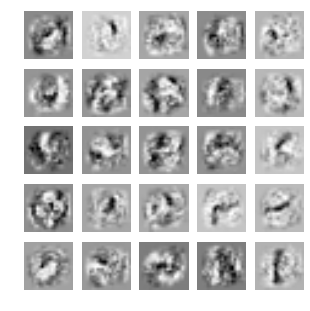

In [101]:
theta1_temp = np.array(b['Theta1'])
rows = np.arange(0,theta1.shape[0])
displayData(theta1_temp[:,1:],rows,5)